In [2]:
import matplotlib.pyplot as plt
import numpy as np

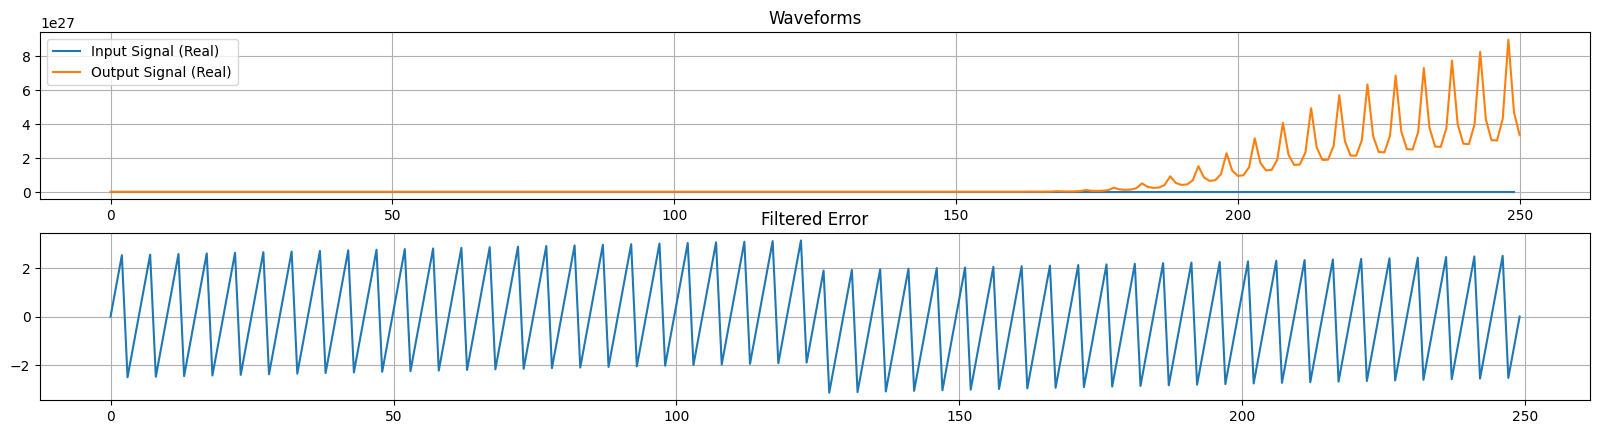

In [45]:
class PhaseDetector:
    def __init__(self) -> None:
        pass

    def proc( self, sigIn, sigOut ):
        phase_in  = np.angle(sigIn)
        phase_out = np.angle(sigOut)
        return phase_in - phase_out


class LoopFilter:
    def __init__( self, K_i, K_p ) -> None:
        self.K_i = K_i
        self.K_p = K_p
        self.integrator = 0
    
    def proc( self, e_D ):
        self.integrator += self.K_i * e_D

        return self.K_p * e_D + self.integrator

class NumericallyControlledOscillator:
    def __init__( self, K_0 ) -> None:
        self.prevPhaseEstimate = 0
        self.K_0 = K_0

    def proc( self, e_F ):
        prev = self.prevPhaseEstimate
        new = prev + self.K_0 * e_F
        self.prevPhaseEstimate = new

        return prev
    

class PhaseLockedLoop:
    def __init__( self, K_i, K_p, K_0, pll_f ) -> None:
        self.pd = PhaseDetector()
        self.lf = LoopFilter( K_i, K_p )
        self.nco = NumericallyControlledOscillator( K_0 )

        self.last_sin_out = 0
        self.last_phase_estimate = 0
        self.pll_f = pll_f

        self.theta = 0


    """
    The original code for this seemed pretty interested in delaying the output by one sample (or something along those lines)
    I took that all out and it appears to still work fine
    """
    def proc( self, in_, ):
        _e_D = self.pd.proc( in_, self.last_sin_out )

        #loop filter
        _e_F = self.lf.proc( _e_D )

        _phase_estimate = self.nco.proc( _e_F )        

        # The phase of our LO, which is additionally modified by the phase coming from our NCO.
        # IDK man, the NCO is a bit of a misnomer because its outputting a phase, not a signal
        self.theta += 2*np.pi*self.pll_f
        if self.theta > 2*np.pi:
            self.theta -= 2*np.pi

        # These were originally n+1
        sig = np.exp(1.0j * self.theta + _phase_estimate )
#         _sin_out = -np.sin( self.theta + _phase_estimate )
#         _cos_out = np.cos( self.theta + _phase_estimate )
#         self.last_out = _cos_out + 1.0j * _sin_out

        self.last_out = sig

        return sig.real, sig.imag, _e_D
k = 1
N = 15
K_p = 0.2667
K_i = 0.0178
K_0 = 1

fs = 50
duration_secs = 5
t = np.linspace(0,duration_secs, int(duration_secs*fs))

in_A      = 1
in_f_Hz   = 10
in_phi    = 0
in_sig    = in_A * np.exp( 2j * np.pi * in_f_Hz * t + in_phi)


# input_signal = np.cos(2*np.pi*(k/N)*t + np.random.normal(0, 0.1, size=len(t)) + np.pi) # Sprinkle in phase noise
# input_signal +=  np.random.normal(0, 0.1, size=len(t)) # AWGN

e_D = [] #phase-error output
cos_out = [0]



pll = PhaseLockedLoop( K_i, K_p, K_0, 10 )
for n in range(len(in_sig)):
    _cos_out, _sin_out, _e_D = pll.proc( in_sig[n] )

    cos_out.append( _cos_out )
    e_D.append( _e_D )



# Create a Figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)

# Set up Axes
ax1 = fig.add_subplot(411)
# ax1.plot(cos_out, label='PLL Output')
ax1.plot(in_sig.real, label='Input Signal (Real)')
ax1.plot(cos_out, label='Output Signal (Real)')

ax1.set_title('Waveforms')

plt.grid()
plt.legend()

ax2 = fig.add_subplot(412)
ax2.plot( e_D )
plt.grid()
ax2.set_title('Filtered Error')
plt.show()